# RNNs for  Temperature Data
# Author: Huygens Ravelomanana
# Description
Using the data from https://storage.googleapis.com/nicksdemobucket/temperatures.csv,
we predict the temperature build different RNN's models:
+ Vanilla RNN
+ LSTM
+ GRU
We then comment on the result

# Importing libraries

In [1]:
%matplotlib inline
# to store the plots within the notebook

# uncomment this line below if running on google colab
%tensorflow_version 2.x 

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting seed for random in order to get reproducible results
random.seed(1)    # python random seed
np.random.seed(1)  # numpy random seed


import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (SimpleRNN, LSTM,
                                     GRU, Conv1D, Flatten,
                                     Dense, TimeDistributed,
                                     BatchNormalization)

from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam, Nadam


from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

sns.set(style="whitegrid")


# Loading data and data exploration.

## We are going to use the temperature data

In [2]:
# getting the data
!wget https://storage.googleapis.com/nicksdemobucket/temperatures.csv


--2021-08-04 03:17:42--  https://storage.googleapis.com/nicksdemobucket/temperatures.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/csv]
Saving to: ‘temperatures.csv.3’

temperatures.csv.3  100%[===================>]  66.33K  --.-KB/s    in 0s      

2021-08-04 03:17:42 (132 MB/s) - ‘temperatures.csv.3’ saved [67921/67921]



In [3]:
# loading the data into a pandas dataframe
temperature_df = pd.read_csv('temperatures.csv')

# visualizing the head of the data
temperature_df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# visualizing the head of the data
temperature_df.tail()

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [5]:
# getting some info on the data
# shape, datatypes
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [6]:
# converting the Date column type to datetime
temperature_df.Date = temperature_df.Date.astype('datetime64[ns]')

# viewing the dataframe data types again
temperature_df.dtypes

Date    datetime64[ns]
Temp           float64
dtype: object

In [7]:
# checking if there are some missing values
temperature_df.isna().any()

Date    False
Temp    False
dtype: bool

In [8]:
# viewing the statistics 
temperature_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


In [9]:
# reviewing the dataframe
temperature_df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


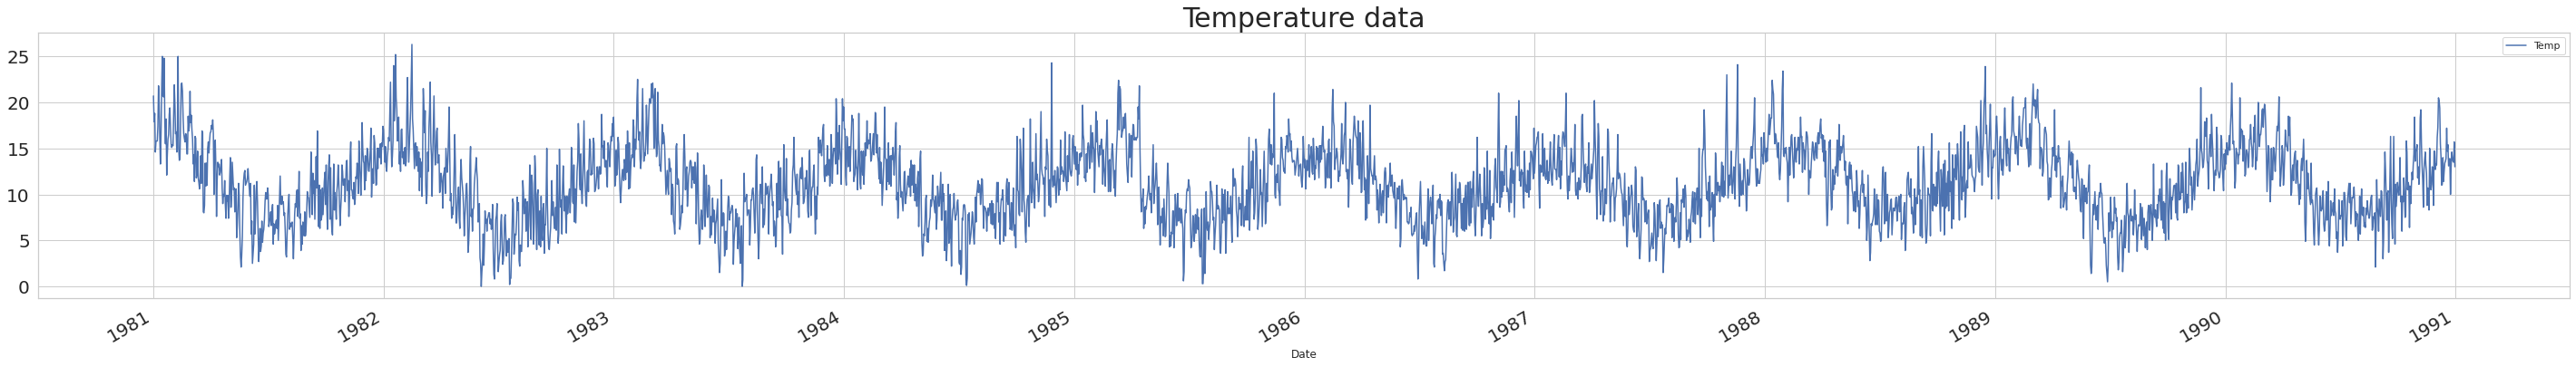

In [10]:
# Visualizing the curve of the data as timeseries
fig, axes = plt.subplots(figsize = (50,6))
_ = temperature_df.plot(ax=axes,
                        x='Date',
                        fontsize=20,
                        title='Temperature data')
axes.title.set_size(30)


**Comment:**
+  The data consists of daily temperature from January 1st 1981 up to December 31 1990 (10 years).
+  The data exhibits clear seasonality.
+  There is no trend (at least at first sight).
+  There are noises as expected for such data.
+  The range varies between 0 and 26.3

# Data Preprocessing

In [11]:
# converting the data into numpy arrays
date_arr = temperature_df.Date.to_numpy()
temperature = temperature_df.Temp.to_numpy()

temperature.shape

(3650,)

## Windowing dataset

In [12]:
# How far ahead we want to predict
HORIZON = 1

# How many consecutive precedent values we are going to use
# to predict the horizon (1 unit is 1 day)
N_TIMESTEPS = 14 

In [13]:

# Creating a function which separate a windowed data into
# predictors and target
def separate_window(window, horizon=1):
  """
    Separate a data (timeseries) window into predictors and  target
    depending on the horizon.

    Input:
    ------
            window (numpy.ndarray):  a 2D array of timeseries stacked
                                     on top of each other
 
            horizon (int): the size of the target.
                           (how far ahead we want to predict)
    Output:
    -------
             predictors  (numpy.ndarray)  and target  (numpy.ndarray)
             both 2D arrays.

             Example:
                 If window = [[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7]]
                    and  horizon=1 then
                    
                    Predictors [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]]
                    Target [[6], [7]]]
             
             That is the Output is : 
                    [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]],   [[6], [7]]

                 If instead horizon=3 then

                    Predictors [[1, 2, 3], [2, 3, 4]]
                    Target [[4, 5, 6], [5, 6, 7]]
                         
            That is the Output is :
                 [[1, 2, 3], [2, 3, 4]],   [[4, 5, 6], [5, 6, 7]]
  """
  return window[:, :-horizon], window[:, -horizon:]

In [14]:
# Creating the predictors and the target data from the the 1D timeseries

def make_windows(series, n_timesteps, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of n_timesteps.
    Function which from a single (1D) timeseries outputs two 2D arrays:

        * The first 2D array is an array whose rows consist of sequential
          values of length n_timesteps 
          (the values are from the 1D input series).
          They play the role of predictors.

        * The second array is a 2D array whose rows consist of pseudofuture
          values whose number equal horizon.
          They play the role of target.
        
        * The the first and second row has the same number of rows
         (number of "data points").
    
    Input:
    -----
          series (numpy.ndarray): a timeseries in the form of an 1D array.

          n_timesteps (int): The number of conosecutive data to be used
                             as predictor
          
          horizon (int):  how far ahead we want to predict, the size of target
                         (i.e number of consecutive values we want to predict)
    
    Output:
    ------
          predictors (numpy.ndarray): 2D array of predictors.

          targets (numpy.ndarray): 2D array of targets.

    Example:
    --------
          If the inputs are:

                series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

                n_timesteps=4 and horizon=1
         
         Then the outputs are:

                predictors = array([[ 1,  2,  3,  4],
                                    [ 2,  3,  4,  5],
                                    [ 3,  4,  5,  6],
                                    [ 4,  5,  6,  7],
                                    [ 5,  6,  7,  8],
                                    [ 6,  7,  8,  9],
                                    [ 7,  8,  9, 10],
                                    [ 8,  9, 10, 11]])
              
               
               targets = array([[ 5],
                                [ 6],
                                [ 7],
                                [ 8],
                                [ 9],
                                [10],
                                [11],
                                [12]])
    """

    # We first create a 2D array whose rows contains both the predictors
    # and the target in time sequential order

    # creating a 2D of indices (the values in the array are indices: 0, 1, ...)
    # with only 1 row:  [0, 1, 2, 3, ..., n_timesteps+horizon-1]
    window_step = np.expand_dims(np.arange(n_timesteps+horizon), axis=0)

    # Adding the other rows indices one after the other to window_step
    # the -1 is because indexing start from 0
    window_indexes = window_step + np.expand_dims(
                                       np.arange(
                                           len(series)-(n_timesteps+horizon-1)
                                                ),
                                       axis=0).T

    # Creating a 2D array using numpy.array indexing on the original timeseries
    # example: if z = np.array([10, 11, 12, 13, 14, 15, 16, 17])
    #          then z[np.array([[0, 1, 2, 3], [4, 5, 6, 7]])] will be
    #          array([[10, 11, 12, 13],
    #                 [14, 15, 16, 17]])
    # see Index arrays and Indexing Multi-dimensional arrays in
    # https://numpy.org/doc/stable/user/basics.indexing.html for more info.
    windowed_array = series[window_indexes]

    # Separating the predictors and the targets into 2 distincts 2D arrays.
    predictors, targets = separate_window(windowed_array, horizon=horizon)

    return predictors, targets

In [15]:
full_windows, full_labels = make_windows(temperature,
                                         n_timesteps=N_TIMESTEPS,
                                         horizon=HORIZON)
full_windows.shape, full_labels.shape

((3636, 14), (3636, 1))

In [16]:
# Viewing some random samples / rows of data
for _ in range(4):
    i = np.random.randint(full_labels.shape[0])
    print(f"Predictors: {full_windows[i]} -> Target: {full_labels[i]}")

Predictors: [15.8 17.2 17.6 12.1 11.4 13.  13.2 12.  15.3 12.7 12.1 13.8 10.9 12. ] -> Target: [16.5]
Predictors: [ 6.6  4.6  7.   6.   5.5  8.1  5.5  6.2  8.  10.3  9.8  9.6  8.5  7.5] -> Target: [11.2]
Predictors: [17.1 17.1 12.  11.  16.3 16.1 13.  13.4 15.2 12.5 14.3 16.5 18.6 18. ] -> Target: [18.2]
Predictors: [7.9 3.3 3.9 6.  4.  5.5 8.5 9.8 9.5 7.2 8.1 8.  8.5 8.8] -> Target: [8.3]


## Turning windows into training and test sets¶


In [17]:
# Make the train/test splits
def cstm_train_test_splits(predictors, targets, test_split=0.1):
  """
  Splits matching pairs of predictor and targets into train and test splits.
  """
  split_size = int(len(predictors) * (1-test_split))
  train_predictors = predictors[:split_size]
  train_targets = targets[:split_size]
  test_predictors = predictors[split_size:]
  test_targets = targets[split_size:]
  return train_predictors, test_predictors, train_targets, test_targets

In [18]:
X_train_val, X_test, y_train_val, y_test = cstm_train_test_splits(full_windows,
                                                                full_labels,
                                                                test_split=0.1)

X_train, X_val, y_train, y_val = cstm_train_test_splits(X_train_val,
                                                        y_train_val,
                                                        test_split=0.15)

In [19]:
# checking the shape of the data
print("\nTrain features shape: ", X_train.shape)
print("Train target shape: ",y_train.shape,"\n")
print("Validation features shape: ", X_val.shape)
print("Validation target shape: ", y_val.shape, "\n")
print("Test features shape: ", X_test.shape)
print("Test target shape: ", y_test.shape, "\n")


Train features shape:  (2781, 14)
Train target shape:  (2781, 1) 

Validation features shape:  (491, 14)
Validation target shape:  (491, 1) 

Test features shape:  (364, 14)
Test target shape:  (364, 1) 



In [20]:
# creating an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# fitting the MinMaxScaler with the train data
#and scaling the train data
X_train = scaler.fit_transform(X_train)

# scaling the validation and test feature using 
# the min max from the train data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
# viewing the new max and min of the train data
X_train.max(), X_train.min(), X_train.mean(), X_train.std()

(1.0, 0.0, 0.42035024271356364, 0.15479939034228987)

In [22]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [23]:
# Defining the maximum and minimum temperature as global constant
MAX_TEMP = scaler.data_max_[0]
MIN_TEMP = scaler.data_min_[0]

# we will scale the y_train and y_val in 0, 1 range
y_train = (y_train - MIN_TEMP) / (MAX_TEMP - MIN_TEMP)
y_val = (y_val - MIN_TEMP) / (MAX_TEMP - MIN_TEMP)

# a scaled version of y_test to be used for evaluation
y_test_scaled = (y_test - MIN_TEMP) / (MAX_TEMP - MIN_TEMP)

# we need to keep y_test as it is since it will just be used for comparison
# at the end, when we test the model on unseen data

In [24]:
#scaler.inverse_transform()

**Comment:**
+ Keras RNN models takes 3D array of type: (n_samples, n_timesteps, n_features) as input.
+ Thus we need to reshape our data into 3D arrays (n_samples, n_timesteps, 1), since we have only one feature.

tf.expand_dims(x, axis=1)


In [25]:
X_train = X_train.reshape(-1, N_TIMESTEPS, 1)
X_val = X_val.reshape(-1, N_TIMESTEPS, 1)
X_test = X_test.reshape(-1, N_TIMESTEPS, 1)

In [26]:
# checking the shape of the  new data
print("\nTrain features shape: ", X_train.shape)
print("Validation features shape: ", X_val.shape)
print("Test features shape: ", X_test.shape)



Train features shape:  (2781, 14, 1)
Validation features shape:  (491, 14, 1)
Test features shape:  (364, 14, 1)


In [27]:
# looking at some samples of train data

print("X_train samples:\n", X_train[14],
      "\n\nThe corresponding y_train samples:\n",
      y_train[:2])


X_train samples:
 [[0.95057034]
 [0.78707224]
 [0.78326996]
 [0.94296578]
 [0.6730038 ]
 [0.58935361]
 [0.69201521]
 [0.46007605]
 [0.54752852]
 [0.60836502]
 [0.62737643]
 [0.71102662]
 [0.73764259]
 [0.6539924 ]] 

The corresponding y_train samples:
 [[0.95057034]
 [0.78707224]]


# Modeling and Forecasting

## Utility Functions

In [28]:
# Creating a function which plots loss or accuracy curve
def plot_train_val_curves(history):
    """Function plotting the train and validation loss and accuracy curves
    INPUT:
    -----   
            history (tensorflow.python.keras.callbacks.History):
                     output of the .fit() method of a keras Model instance
    OUTPUT:
    ------
            None (it shows some plots)
    """

    # creating figure and axis for the plot
    fig, axes = plt.subplots(1,2, figsize=(20,8))

    # train and validation loss plot
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Loss Progress During Training', fontsize=15)
    axes[0].set_ylabel('Training and Validation Loss', fontsize=12)
    axes[0].set_xlabel('Epoch number', fontsize=12)
    axes[0].legend(['Training Loss', 'Validation Loss'], fontsize=12)

    # train and validation accuracy plot
    axes[1].plot(history.history['last_time_step_mse'])
    axes[1].plot(history.history['val_last_time_step_mse'])
    axes[1].set_title('Model last_time_step_mse Progress', fontsize=15)
    axes[1].set_ylabel('last_time_step_mse', fontsize=12)
    axes[1].set_xlabel('Epoch number', fontsize=12)
    axes[1].legend(['Training last_time_step_mse',
                    'Validation last_time_step_mse'], fontsize=12)

    plt.show()



In [29]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Input:
    ------  
            model (tensorflow.python.keras.engine.sequential.Sequential):
                 an already fitted / trained model.
            
            input_data (numpy.ndarray): windowed data of shape
                                       (n_samples, N_TIMESTEPS, 1)
    Output:
    ------
            forecasted (predicted) values.
    """

    forecast = model.predict(input_data)
     
     # return 1D array of predictions
    return tf.squeeze(forecast)

In [30]:
def plot_prediction(y_test, predictions):
    """Plot the observed test data (pseudo-future) and the forecasted values
    on the same axis.
    
    Input:
    ------
            y_test (numpy.ndarray): the test data.
            
            predictions (numpy.ndarray): the forecasts.
    """

    test_days = np.arange(0, len(y_test), 1, dtype='int32')
    plt.figure(figsize=(40, 8))
    plt.plot(test_days, y_test, label="True Value", color='g', linewidth=4)
    plt.plot(test_days, predictions, label="Prediction", color='r', linewidth=4)
    plt.xlabel("Days", fontsize=40)
    plt.xticks(fontsize=25)
    plt.ylabel("Temperature", fontsize=40)
    plt.yticks(fontsize=25)
    plt.suptitle("Observed vs Forecasted Temperature", fontsize=50)
    plt.legend(fontsize=30, loc='upper center')
    plt.show()

In [31]:
def plot_residual_hist(residual):
    """Plot the histogram of the residual to see what type of distribution
       the residual follows.
    Input:
    ------
            residual (numpy.ndarray): Should be a residual i.e difference
                                      between observation and forecast.
    """
    
    plt.figure(figsize=(8, 8))
    plt.xlabel("Residual values", fontsize=20)
    plt.hist(residual, bins='auto')
    plt.xticks(fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.yticks(fontsize=15)
    plt.suptitle("Histogram of residual",
                 fontsize=25)
    plt.show()

In [32]:
def plot_residual(residual):
    """Plots the curve of the input: residual.
    
    Input:
    ------
            residual (numpy.ndarray): Should be a residual i.e difference
                                      between observation and forecast.
    """

    #test_days = np.arange(0, len(y_test), 1, dtype='int32')
    plt.figure(figsize=(40, 4))
    
    n = len(y_test)
    test_days = np.arange(0, n, 1, dtype='int32')
    plt.plot(test_days,
             residual,
             linestyle='--',
             marker='o',
             color='#FFA500',
             linewidth=4)
    
    #adds thick line @ y=0
    plt.axhline(linewidth=4, color='k') 

    # fill band
    y1 = [-2.3] * n
    y2 = [2.3] * n
    plt.fill_between(test_days,
                    y1, y2,
                    color='C0', 
                    alpha=0.3)

    plt.xlabel("Days", fontsize=40)
    plt.xticks(fontsize=25)
    plt.ylabel("Difference", fontsize=40)
    plt.yticks(fontsize=25)
    plt.suptitle("Differences between observations and predictions",
                 fontsize=50)
    plt.show()



In [33]:
# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    GREEN = '\033[32m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

# finction showing some summary of the test result
def test_summary(model):
    """Test the model on the globally defined test data (pseudo-future)
       Print test summary and the plot of prediction vs forecast.
       
       Input:
       -----
               model (tensorflow.python.keras.engine.sequential.Sequential):
                        an already fitted model in the RNN family
    """
    # predict using the test predictors
    y_pred = make_preds(model, X_test)

    y_pred = y_pred * (MAX_TEMP - MIN_TEMP) + MIN_TEMP

    # reshaping y_test and prediction into the same numpy array shape
    y_test_reshaped = y_test.copy().reshape((-1,))
    y_pred = y_pred.numpy()
    residual = y_test_reshaped - y_pred

    # Printing test scores and report
    print(bcolors.BOLD + bcolors.GREEN +\
        '\n Observed mean: ' + bcolors.ENDC + bcolors.ENDC,
        tf.reduce_mean(y_test).numpy())

    print(bcolors.BOLD + bcolors.RED +\
        '\n Predicted mean: ' + bcolors.ENDC + bcolors.ENDC,
        tf.reduce_mean(y_pred).numpy())

    mae = mean_absolute_error(y_test_reshaped, y_pred)
    mae = mae.numpy()

    print(bcolors.BOLD +\
        '\n Mean absolute error: ' + bcolors.ENDC,
        mae, "degree")
    

    # plot the prediction
    plot_prediction(y_test, y_pred)

    # space
    print("\n\n")

    # return residual for plotting in another cell
    return residual

    

In [34]:
# function showing info about the residual distribution
def show_residual_dist(residual):
    """Shows the mean, variance and standard deviation of the input: residual.
    Input:
    ------
            residual (numpy.ndarray): Should be a residual i.e difference
                                      between observation and forecast.
    """
    residual_mean = residual.mean()
    residual_var = residual.var()
    residual_std = np.sqrt(residual_var)

    # printing the mean, variance and standard deviation
    print(bcolors.BOLD +\
    "\nResidual's mean: " + bcolors.ENDC,
    residual_mean)

    print(bcolors.BOLD +\
    "\nResidual's variance: " + bcolors.ENDC,
    residual_var)

    print(bcolors.BOLD +\
    "\nResidual's standard deviation: " + bcolors.ENDC,
    residual_std, "\n\n")

    # plotting the histogram
    plot_residual_hist(residual)

## Deep RNNs model

### Model creation and training (Deep RNN)



In [35]:
# defining a learning rate scheduler function
# we will also use this for the other times of model
def scheduler(epoch, lr):
    """ Learning rate scheduler
    INPUT:
    ------         
          epochs (int): current number of epoch.

          lr (float): initial learning rate
    
    OUTPUT:
    -------
          (float) learning rate for the corresponding epoch
    """

    if epoch < 50: 
        return lr
    else:
        return lr * tf.math.exp(0.08*(50-epoch))

In [36]:
# we will use this as metrics for all the 3 models
def last_time_step_mse(Y_true, Y_pred):
  return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [37]:
#bias_initializer = tf.keras.initializers.Constant(
#                        value=X_train.mean()
#                        )

# Function creating our Deep RNN model
# we put it in a function so that we can run
# creating and fitting on the same cell

def create_Deep_RNN():
    """ Creates a Deep_RNN model
    Input:
    ------  None

    Output:
    ------
           DeepRNN_model:
                 (tensorflow.python.keras.engine.sequential.Sequential)
                 a compiled model.
    """

    ############  Creating Deep RNN model #########################

    # creating a new instance of Sequential
    DeepRNN_model = Sequential()

    # 1st simple RNN layer
    DeepRNN_model.add(SimpleRNN(5,
                                kernel_initializer="lecun_normal",
                                bias_initializer="lecun_normal",
                                return_sequences=True,
                                input_shape=[N_TIMESTEPS, 1]))

    # 2nd simple RNN layer
    DeepRNN_model.add(SimpleRNN(2,
                                kernel_initializer="lecun_normal",
                                bias_initializer="lecun_normal"))

    # adding last layer: Dense
    DeepRNN_model.add(Dense(1))

    ############  End creation ####################################

    # compiling the model
    DeepRNN_model.compile(loss='mse',
                        optimizer='adam',
                        metrics=[last_time_step_mse])
    
    # return model
    return DeepRNN_model

In [38]:
%%time

K.clear_session()

tf.random.set_seed(1)

# creating our DeepRNN model
DeepRNN_model = create_Deep_RNN()

# we are using early stopping callback to prevent the model from
# training for more epochs than needed, it will save time and resources.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                              patience=8)

# learning rate scheduler
lambda_scheduler = lambda _ : scheduler( _ , 0.01)
lr_sched = LearningRateScheduler(lambda_scheduler)

# fitting the model
DeepRNN_history = DeepRNN_model.fit(X_train,
                                    y_train,
                                    batch_size=64,
                                    epochs=1000,
                                    validation_data=(X_val, y_val),
                                    callbacks=[lr_sched, early_stop],
                                    verbose=2)


Epoch 1/1000
44/44 - 3s - loss: 3.6348 - last_time_step_mse: 3.5921 - val_loss: 0.1630 - val_last_time_step_mse: 0.1598
Epoch 2/1000
44/44 - 1s - loss: 0.0394 - last_time_step_mse: 0.0391 - val_loss: 0.0236 - val_last_time_step_mse: 0.0233
Epoch 3/1000
44/44 - 1s - loss: 0.0223 - last_time_step_mse: 0.0222 - val_loss: 0.0230 - val_last_time_step_mse: 0.0229
Epoch 4/1000
44/44 - 1s - loss: 0.0218 - last_time_step_mse: 0.0216 - val_loss: 0.0229 - val_last_time_step_mse: 0.0229
Epoch 5/1000
44/44 - 1s - loss: 0.0211 - last_time_step_mse: 0.0211 - val_loss: 0.0222 - val_last_time_step_mse: 0.0223
Epoch 6/1000
44/44 - 1s - loss: 0.0199 - last_time_step_mse: 0.0199 - val_loss: 0.0198 - val_last_time_step_mse: 0.0197
Epoch 7/1000
44/44 - 1s - loss: 0.0175 - last_time_step_mse: 0.0175 - val_loss: 0.0171 - val_last_time_step_mse: 0.0171
Epoch 8/1000
44/44 - 1s - loss: 0.0143 - last_time_step_mse: 0.0143 - val_loss: 0.0135 - val_last_time_step_mse: 0.0135
Epoch 9/1000
44/44 - 1s - loss: 0.0114 -

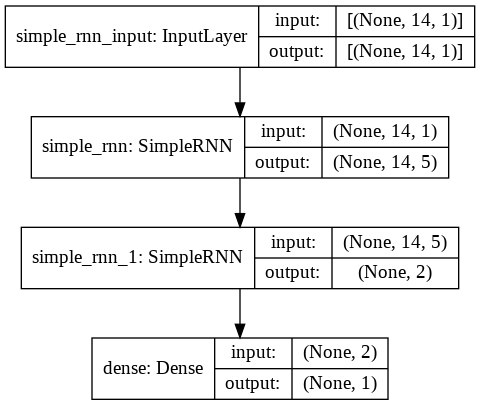

In [39]:
# plotting the model
plot_model(DeepRNN_model,
           show_shapes=True,
           show_layer_names=True)

In [40]:
# printing a model summary
DeepRNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 14, 5)             35        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2)                 16        
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


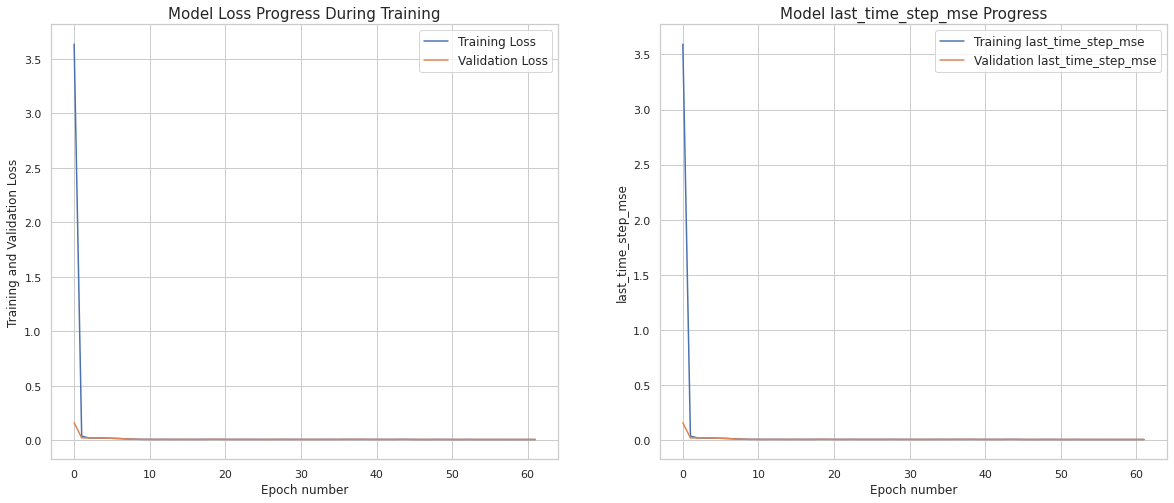

In [41]:
# plotting
plot_train_val_curves(DeepRNN_history)

### Testing / Forecasting on Unseen data (Deep RNN)

In [42]:
# test mean square error loss
DeepRNN_model.evaluate(X_test, y_test_scaled)

12/12 [==============================] - 0s 4ms/step - loss: 0.0073 - last_time_step_mse: 0.0071


[0.007320099510252476, 0.00714404322206974]


 Observed mean:  11.66098901098901

 Predicted mean:  11.616278

 Mean absolute error:  1.7352011 degree


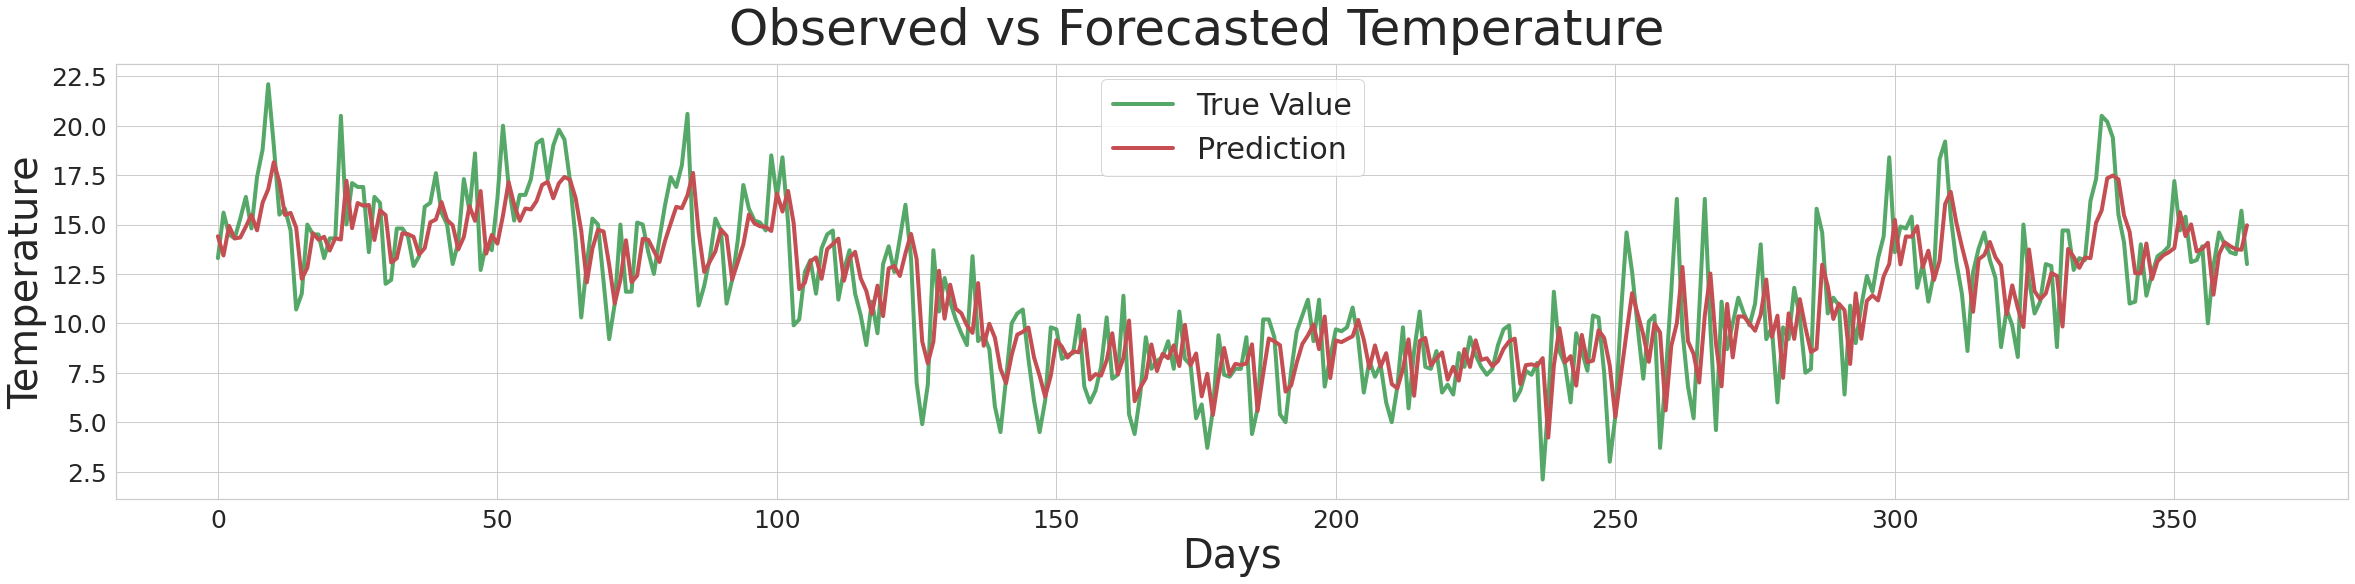

In [43]:
DeepRNN_residual = test_summary(DeepRNN_model)

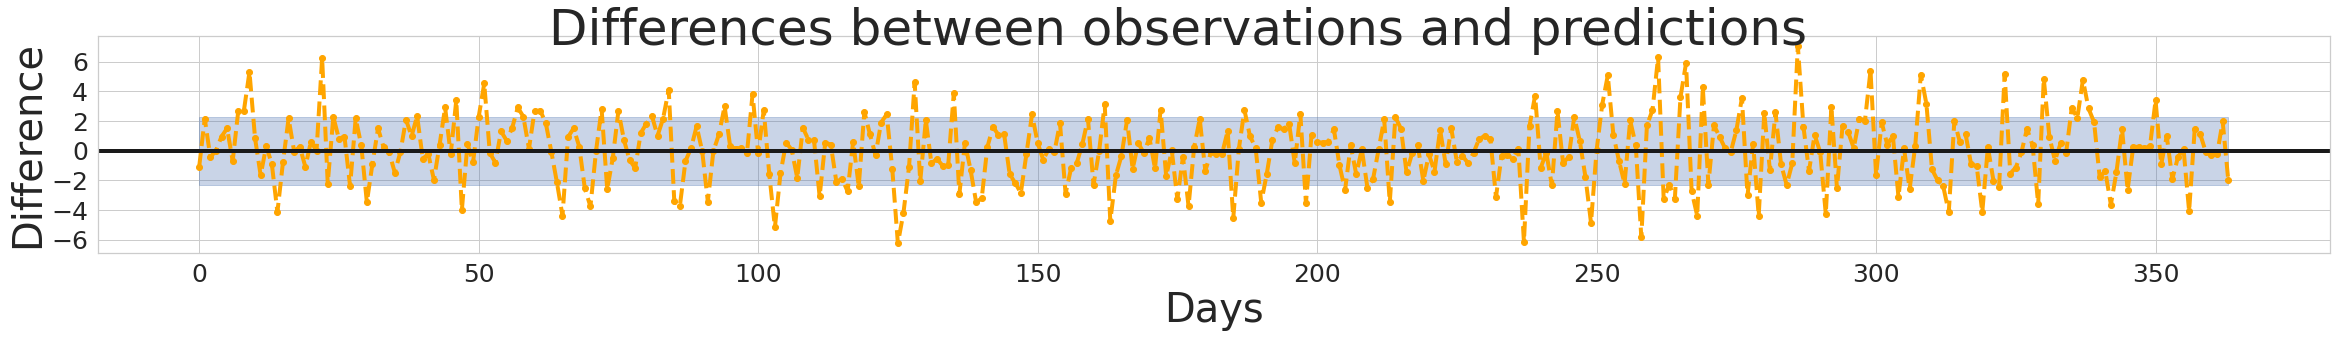

In [44]:
# plotting the curve of residual
plot_residual(DeepRNN_residual)


Residual's mean:  0.04471051195165614

Residual's variance:  5.061240779064268

Residual's standard deviation:  2.249720155722544 




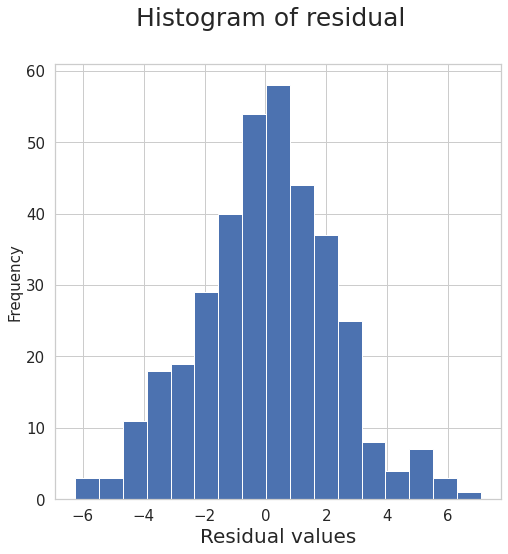

In [45]:
# More info on the residual distribution
show_residual_dist(DeepRNN_residual)

## LSTM model

### Model creation and training (LSTM)


In [46]:

# Function creating our LSTM model
# we put it in a function so that we can run
# creating and fitting on the same cell

def create_LSTM():
    """ Creates an custom Made LSTM model
    Input:
    ------  None

    Output:
    ------
           LSTM_model:
                 (tensorflow.python.keras.engine.sequential.Sequential)
                 a compiled model.
    """

    ############  Creating Deep RNN model #########################

    # creating a new instance of Sequential
    LSTM_model = Sequential()

    # we added 1D convolutions to see if we can get better result

    # 1st 1D convolution
    LSTM_model.add(Conv1D(filters=30,   # 20
                        kernel_size=2,
                        padding="causal",
                        activation="relu",
                        dilation_rate=1,
                        input_shape=[N_TIMESTEPS, 1]))

    # 2nd 1D convolution
    LSTM_model.add(Conv1D(filters=20,   # 10
                        kernel_size=1,
                        padding="causal",
                        activation="relu",
                        dilation_rate=1))

    # 3rd 1D convolution
    LSTM_model.add(Conv1D(filters=10,
                        kernel_size=1,
                        padding="causal",
                        activation="relu",
                        dilation_rate=1))

    # 1st LSTM layer
    LSTM_model.add(LSTM(32,
                        kernel_initializer="glorot_uniform",
                        input_shape=[N_TIMESTEPS, 1],
                        return_sequences=True))

    # 2nd LSTM layer
    LSTM_model.add(LSTM(16,
                        kernel_initializer="glorot_uniform",
                        input_shape=[N_TIMESTEPS, 1],
                        return_sequences=True))

    # 3rd LSTM layer
    LSTM_model.add(LSTM(16,
                        kernel_initializer="glorot_uniform",
                        input_shape=[N_TIMESTEPS, 1]))#,
                        #return_sequences=True))

    # LSTM_model.add(Flatten())
                
    # LSTM_model.add(Dense(40,activation='tanh'))

    # final layer: Dense 1
    LSTM_model.add(Dense(1,
                        activation='tanh'))

    ############  End Creation #########################


    # compiling the model
    LSTM_model.compile(loss='mse',
                        optimizer='adam',
                        metrics=[last_time_step_mse])
    
    # returning the model
    return LSTM_model

In [47]:
%%time

K.clear_session()

tf.random.set_seed(1)

# creating our LSTM model
LSTM_model = create_LSTM()

# we are using early stopping callback to prevent the model from
# training for more epochs than needed, it will save time and resources.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                              patience=15)

# learning rate scheduler
lambda_scheduler = lambda _ : scheduler( _ , 0.001)
lr_sched = LearningRateScheduler(lambda_scheduler)

LSTM_history = LSTM_model.fit(X_train,
                              y_train,
                              batch_size=32,
                              epochs=1000,
                              validation_data=(X_val, y_val),
                              callbacks=[lr_sched, early_stop],
                              verbose=2)

Epoch 1/1000
87/87 - 6s - loss: 0.0304 - last_time_step_mse: 0.0304 - val_loss: 0.0128 - val_last_time_step_mse: 0.0125
Epoch 2/1000
87/87 - 1s - loss: 0.0129 - last_time_step_mse: 0.0129 - val_loss: 0.0115 - val_last_time_step_mse: 0.0113
Epoch 3/1000
87/87 - 1s - loss: 0.0127 - last_time_step_mse: 0.0127 - val_loss: 0.0128 - val_last_time_step_mse: 0.0125
Epoch 4/1000
87/87 - 1s - loss: 0.0127 - last_time_step_mse: 0.0127 - val_loss: 0.0115 - val_last_time_step_mse: 0.0112
Epoch 5/1000
87/87 - 1s - loss: 0.0124 - last_time_step_mse: 0.0124 - val_loss: 0.0129 - val_last_time_step_mse: 0.0127
Epoch 6/1000
87/87 - 1s - loss: 0.0126 - last_time_step_mse: 0.0126 - val_loss: 0.0109 - val_last_time_step_mse: 0.0107
Epoch 7/1000
87/87 - 1s - loss: 0.0127 - last_time_step_mse: 0.0127 - val_loss: 0.0112 - val_last_time_step_mse: 0.0110
Epoch 8/1000
87/87 - 1s - loss: 0.0121 - last_time_step_mse: 0.0121 - val_loss: 0.0110 - val_last_time_step_mse: 0.0107
Epoch 9/1000
87/87 - 1s - loss: 0.0124 -

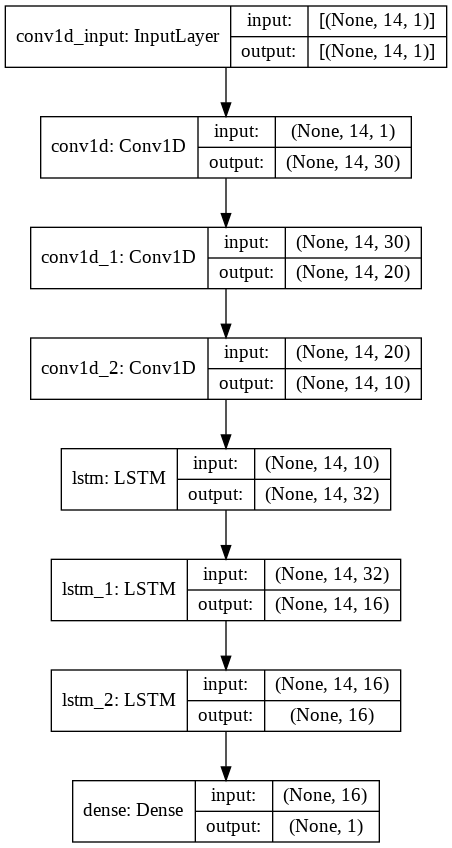

In [48]:
# plot the configuration of the model
plot_model(LSTM_model,
           show_shapes=True,
           show_layer_names=True)

In [49]:
# plot a summary of the model
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 30)            90        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 20)            620       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14, 10)            210       
_________________________________________________________________
lstm (LSTM)                  (None, 14, 32)            5504      
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 1

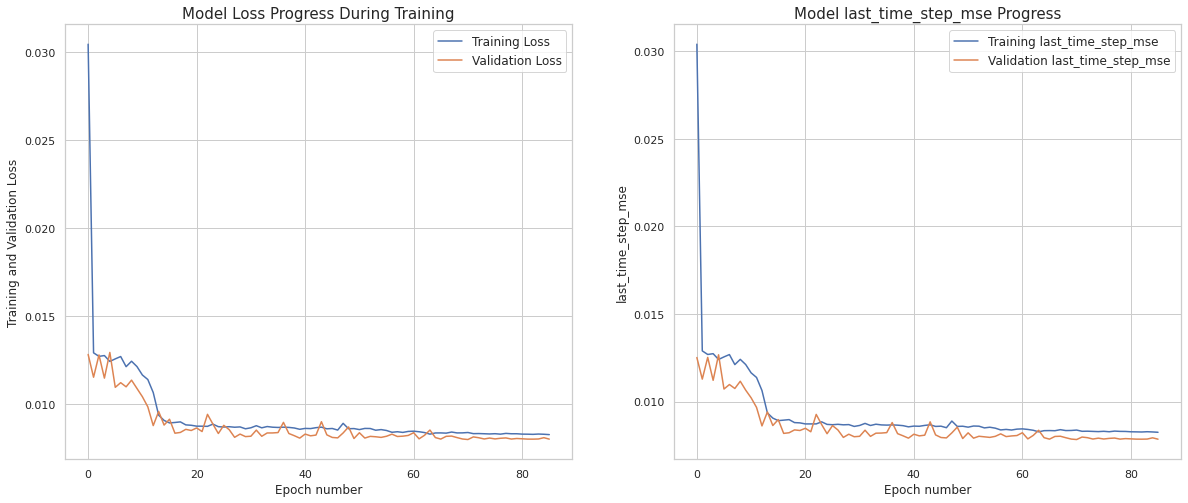

In [50]:
plot_train_val_curves(LSTM_history)

### Testing  / Forecasting on Unseen data (LSTM)

In [51]:
# test mean square error loss
LSTM_model.evaluate(X_test, y_test_scaled)

12/12 [==============================] - 0s 4ms/step - loss: 0.0072 - last_time_step_mse: 0.0070


[0.007164159324020147, 0.007009304594248533]


 Observed mean:  11.66098901098901

 Predicted mean:  11.709611

 Mean absolute error:  1.7231442 degree


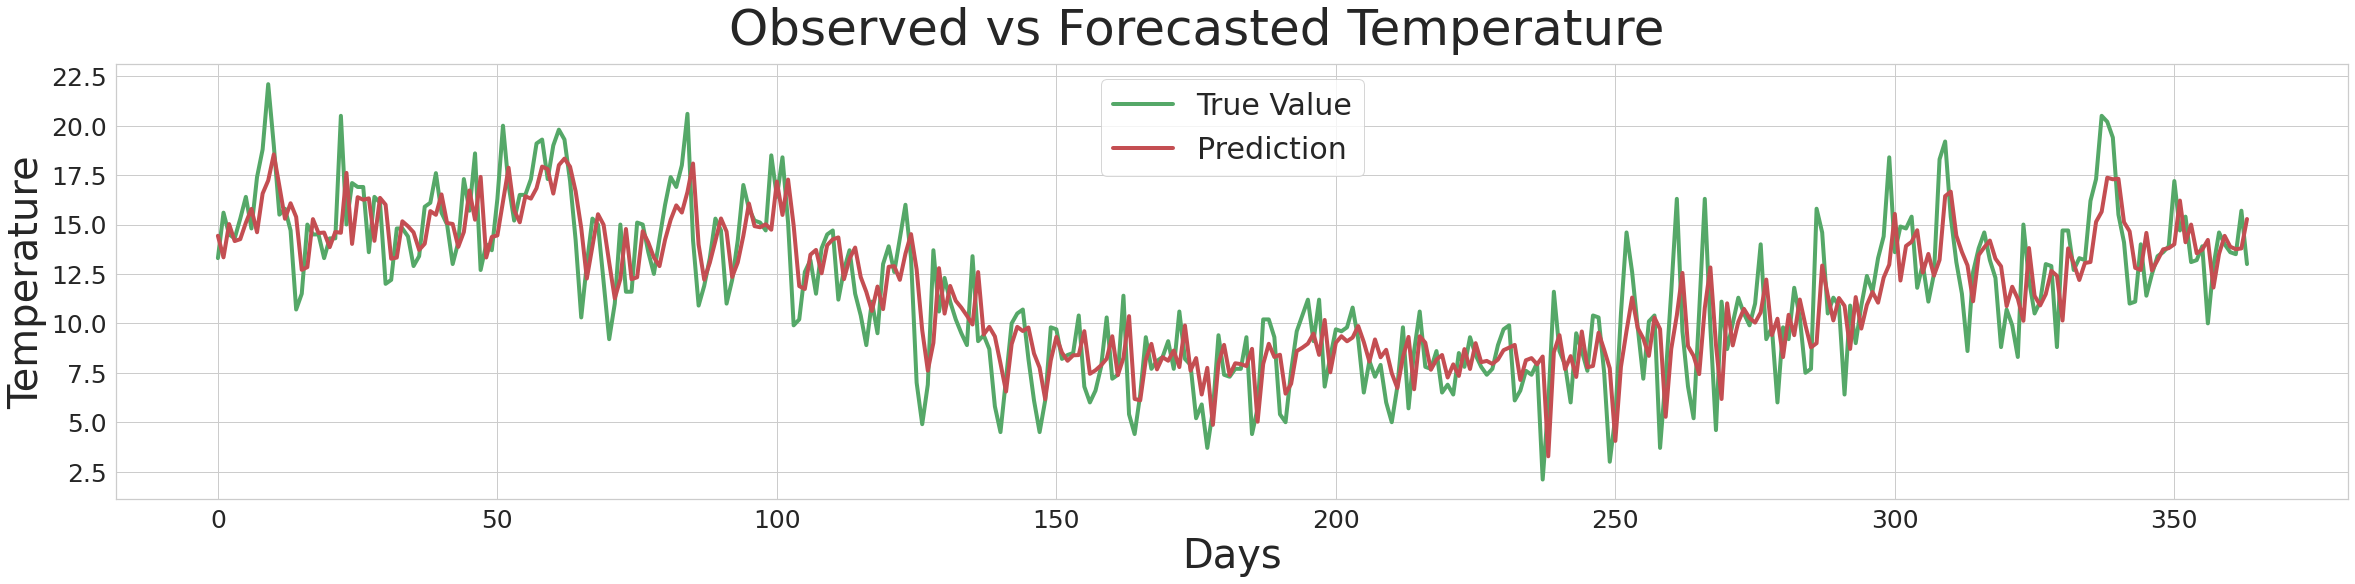

In [52]:
LSTM_residual = test_summary(LSTM_model)

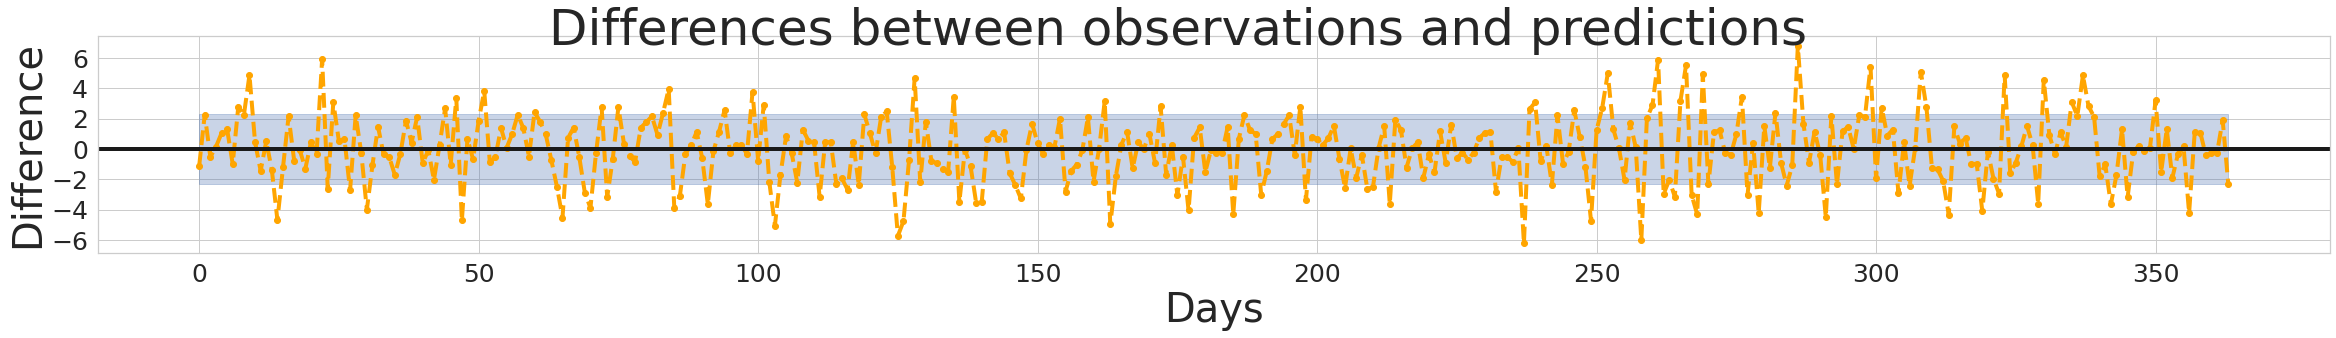

In [53]:
# plotting the curve of residual
plot_residual(LSTM_residual)


Residual's mean:  -0.048621740052988235

Residual's variance:  4.953013052757981

Residual's standard deviation:  2.225536576369389 




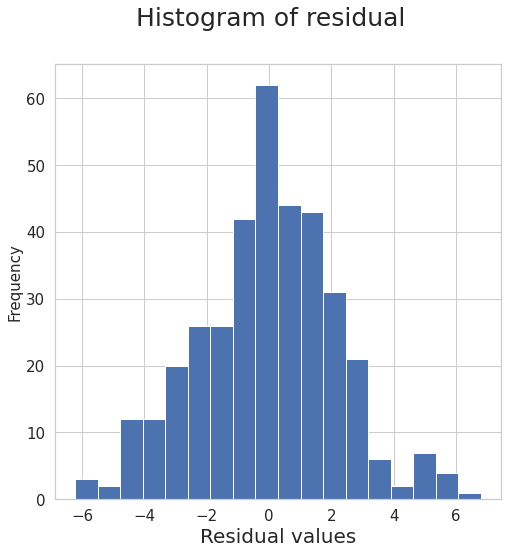

In [54]:
# More info on the residual distribution
show_residual_dist(LSTM_residual)

## GRU model

### Model creation and training (GRU)

In [55]:


# Function creating our LSTM model
# we put it in a function so that we can run
# creating and fitting on the same cell

def create_GRU():
    """ Creates an custom Made GRU model
    Input:
    ------  None

    Output:
    ------
            GRU_model:
                 (tensorflow.python.keras.engine.sequential.Sequential)
                 a compiled model.
    """
    ############  Creating Deep RNN model #########################

    # creating a new instance of Sequential
    GRU_model = Sequential()

    # adding 1D convolutions to see if we can get better result

    # 1st 1D convolution
    GRU_model.add(Conv1D(filters=20,
                        kernel_size=2,
                        padding="causal",
                        activation="relu",
                        dilation_rate=1,
                        input_shape=[N_TIMESTEPS, 1]))

    # 2nd 1D convolution
    GRU_model.add(Conv1D(filters=10,
                        kernel_size=1,
                        padding="causal",
                        activation="relu",
                        dilation_rate=1))

    # 1st GRU layer
    GRU_model.add(GRU(10,
                    return_sequences=True))

    # 2nd GRU layer
    GRU_model.add(GRU(8,
                    return_sequences=True))

    # 3rd GRU layer
    GRU_model.add(GRU(8,
                    return_sequences=True))

    # 4th GRU layer
    GRU_model.add(GRU(8))

    # final Dense layer
    GRU_model.add(Dense(1, activation='tanh'))

    ############  End Creation ##############################

    # compiling the model
    GRU_model.compile(loss="mse",
                    optimizer='adam',
                    metrics=[last_time_step_mse])

    # returning the model
    return GRU_model

In [56]:
%%time
K.clear_session()

tf.random.set_seed(1)

# creating our GRU model
GRU_model = create_GRU()

# we are using early stopping callback to prevent the model from
# training for more epochs than needed, it will save time and resources.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                              patience=14)

# learning rate scheduler
lambda_scheduler = lambda _ : scheduler( _ , 0.001)
lr_sched = LearningRateScheduler(lambda_scheduler)

# fitting the model
GRU_history = GRU_model.fit(X_train,
                            y_train,
                            batch_size=64,
                            epochs=1000,
                            validation_data=(X_val, y_val),
                            callbacks=[lr_sched, early_stop],
                            verbose=2)


Epoch 1/1000
44/44 - 6s - loss: 0.0549 - last_time_step_mse: 0.0544 - val_loss: 0.0210 - val_last_time_step_mse: 0.0210
Epoch 2/1000
44/44 - 0s - loss: 0.0191 - last_time_step_mse: 0.0191 - val_loss: 0.0186 - val_last_time_step_mse: 0.0185
Epoch 3/1000
44/44 - 0s - loss: 0.0170 - last_time_step_mse: 0.0169 - val_loss: 0.0154 - val_last_time_step_mse: 0.0153
Epoch 4/1000
44/44 - 0s - loss: 0.0139 - last_time_step_mse: 0.0138 - val_loss: 0.0118 - val_last_time_step_mse: 0.0118
Epoch 5/1000
44/44 - 0s - loss: 0.0121 - last_time_step_mse: 0.0121 - val_loss: 0.0112 - val_last_time_step_mse: 0.0112
Epoch 6/1000
44/44 - 0s - loss: 0.0121 - last_time_step_mse: 0.0121 - val_loss: 0.0113 - val_last_time_step_mse: 0.0112
Epoch 7/1000
44/44 - 0s - loss: 0.0121 - last_time_step_mse: 0.0121 - val_loss: 0.0112 - val_last_time_step_mse: 0.0111
Epoch 8/1000
44/44 - 0s - loss: 0.0121 - last_time_step_mse: 0.0122 - val_loss: 0.0111 - val_last_time_step_mse: 0.0111
Epoch 9/1000
44/44 - 0s - loss: 0.0120 -

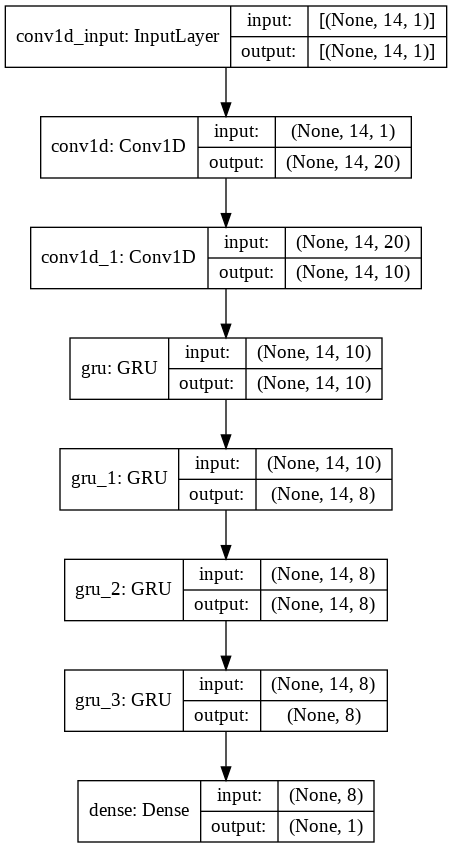

In [57]:
# plotting the structure of the model
plot_model(GRU_model,
           show_shapes=True,
           show_layer_names=True)

In [58]:
# printing a summary of the model
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 20)            60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 10)            210       
_________________________________________________________________
gru (GRU)                    (None, 14, 10)            660       
_________________________________________________________________
gru_1 (GRU)                  (None, 14, 8)             480       
_________________________________________________________________
gru_2 (GRU)                  (None, 14, 8)             432       
_________________________________________________________________
gru_3 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense (Dense)                (None, 1)                 9

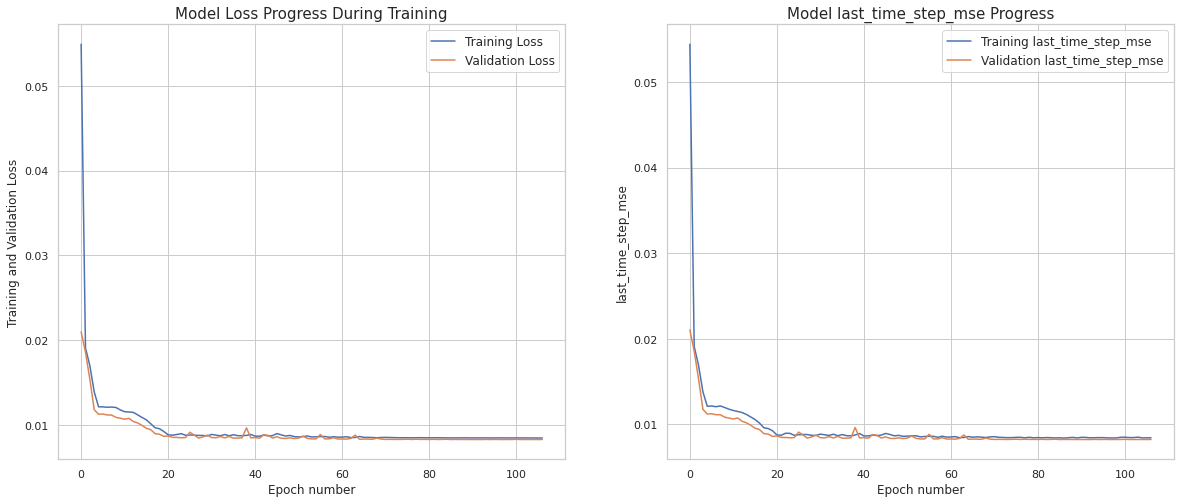

In [59]:
plot_train_val_curves(GRU_history)

### Testing / Forecasting on Unseen data (GRU)

In [60]:
# test mean square error loss
GRU_model.evaluate(X_test, y_test_scaled)

12/12 [==============================] - 0s 4ms/step - loss: 0.0073 - last_time_step_mse: 0.0072


[0.007337344344705343, 0.007151774596422911]


 Observed mean:  11.66098901098901

 Predicted mean:  11.594208

 Mean absolute error:  1.740359 degree


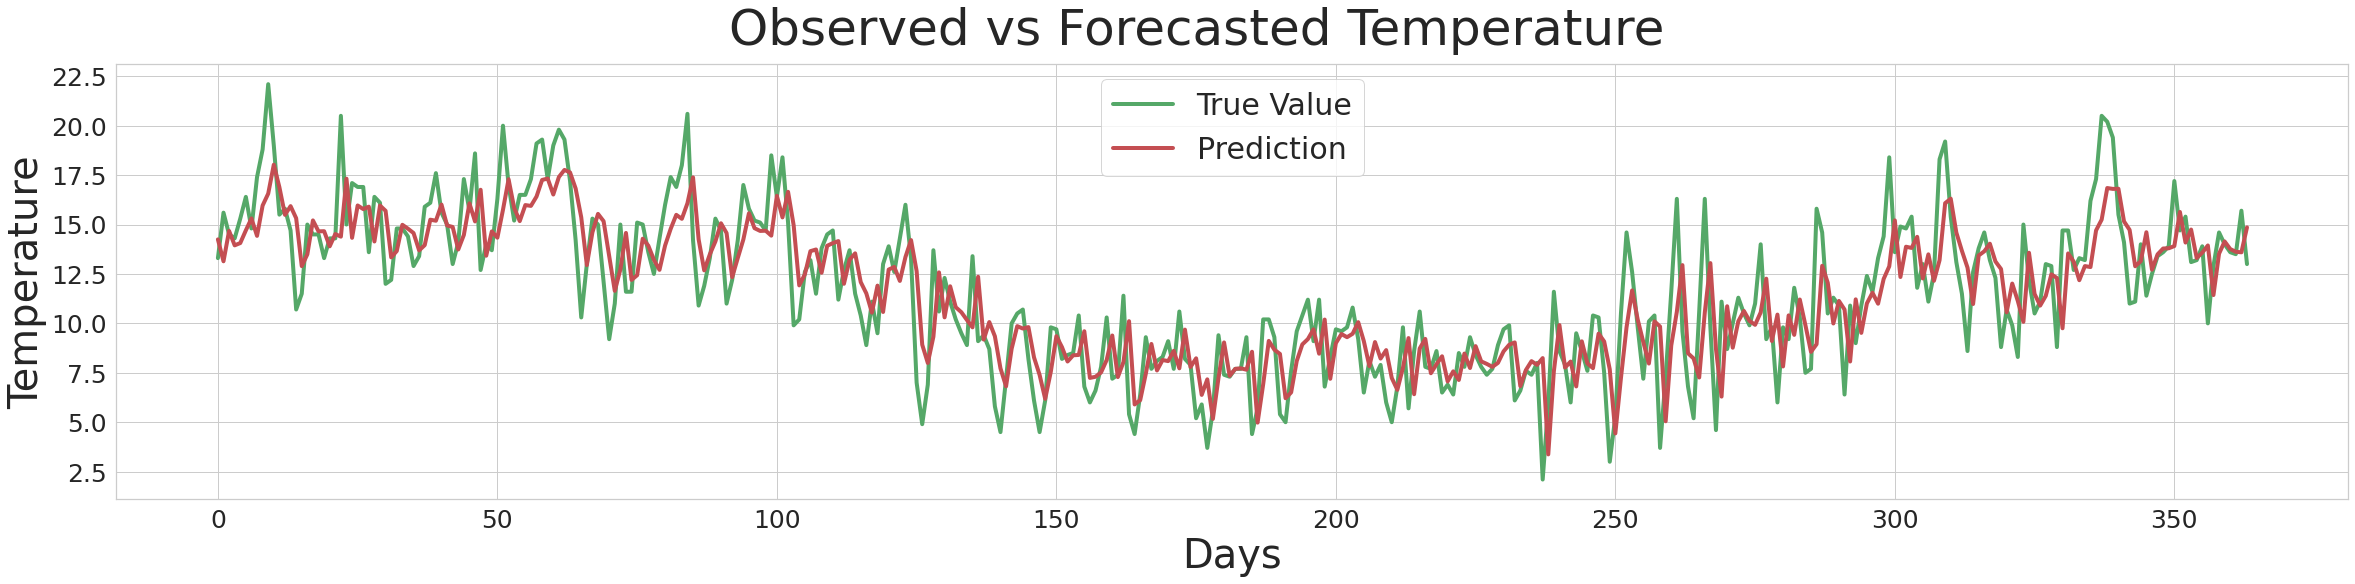

In [61]:
GRU_residual = test_summary(GRU_model)

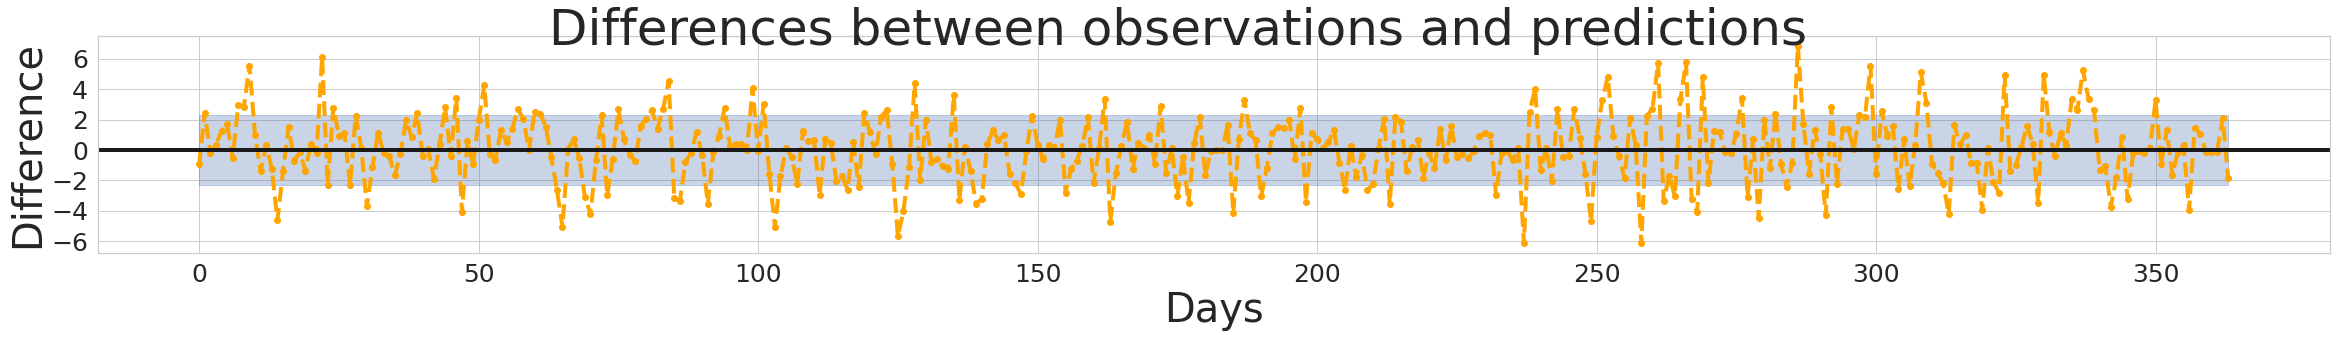

In [62]:
# plotting the curve of residual
plot_residual(GRU_residual)


Residual's mean:  0.06678153551541842

Residual's variance:  5.070707744136338

Residual's standard deviation:  2.251823204458187 




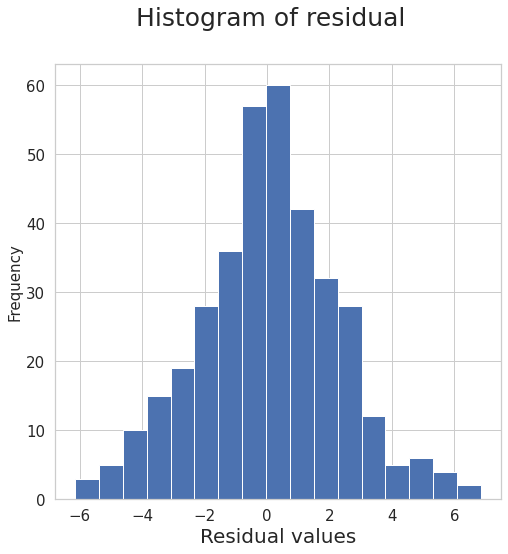

In [63]:
# More info on the residual distribution
show_residual_dist(GRU_residual)

# Final Comments.
+ All the 3 models were able to extract the cycle or seasonality of the data.
+ Their mean absolute error were between 1.7 degree and 1.79 degree.
+ The residual for all the 3 models all had the shape of a normal distribution with mean around 0 and standard deviation around 2.3.
+ If the temperature we have are weather temperature, the acceptable temperature difference between future value and forecast  (in classical meteorology) should be between -1 and 1 so we are a little bit off. However we have less features than what is usually used classicaly. We are missing humidity, pressure, wind and topography.
+ It could have been probably simpler to use pandas.DataFrame .shift() method to create the windowed data but the functions we have defined will still work for multiples features and greater than one horizon.